In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [5]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        uniqueModelsToKeep.append(uniqueModels[i])
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [20]:
uniqueModels = getAllUniqueModels()[-10:]

***ORIGINAL MODELS***
((10, ('IWD', 16, None, None, 2), 10, 'SLV'), 10, 100)
((5, ('GDX', 15, None, None, 3), 3, 'EFA'), 5, 50)
((5, ('SLV', 6, None, 8, 3), 10, 'IWD'), 5, 150)
((22, ('DVY', 13, 21, None, 3), 10, 'IWO'), 22, 150)
((5, ('USO', 4, 22, None, 1), 10, 'VGK'), 5, 25)
((10, ('GDX', 15, None, None, 3), 7, 'EFA'), 10, 300)
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 150)
((10, ('TIP', 27, None, 10, 3), 7, 'VO'), 10, 300)
((5, ('DXJ', 1, None, None, 2), 10, 'EWW'), 5, 150)
((5, ('VIG', 7, None, 18, 1), 7, 'SPY'), 5, 25)
((44, ('IWD', 16, None, None, 2), 3, 'SLV'), 44, 150)
((10, ('AGG', 40, None, None, 2), 5, 'IWD'), 10, 25)
((10, ('GLD', 38, None, None, 3), 7, 'IVW'), 10, 150)
((5, ('IAU', 22, 14, None, 3), 3, 'VB'), 5, 300)
((5, ('SDY', 21, None, None, 3), 3, 'XLB'), 5, 100)
((5, ('XBI', 20, 1, None, 3), 10, 'EFA'), 5, 50)
((22, ('IWD', 13, 9, 11, 1), 3, 'VB'), 22, 25)
((10, ('USO', 3, 2, None, 2), 3, 'XLE'), 10, 150)
((5, ('FXE', 14, None, None, 3), 3, 'IWM'), 5, 50)
((44, (

In [21]:
# uniqueModels = getUniqueModelsForTicker("VGK")

In [26]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    cleanedModels = []
    for mod in allModels:
        
        try:
            algoReturn, algoPredictions = dataAck.getModelData(mod)
            print(mod.describe())
            algoReturn.columns = [str(mod.describe())]
            algoPredictions.columns = [str(mod.describe())]
            if aggregateReturns is None:
                aggregateReturns = algoReturn
                aggregatePredictions = algoPredictions
            else:
                aggregateReturns = aggregateReturns.join(algoReturn)
                aggregatePredictions = aggregatePredictions.join(algoPredictions)
            cleanedModels.append(mod)
        except:
            print("SKIPPING", mod.describe())
    return aggregateReturns, aggregatePredictions, cleanedModels

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
#         if mod.inputSeries.series.ticker not in tickersRequired:
#             tickersRequired.append(mod.inputSeries.series.ticker)
#         if mod.inputSeries.targetTicker not in tickersTraded:
#             tickersTraded.append(mod.inputSeries.targetTicker)

    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions, cleanedModels = generateAllReturnsFromCache(uniqueModels)
    
    return cleanedModels, modelReturns, modelPredictions, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [27]:
factorToTrade = "SPY"
uniqueModels, modelReturns, modelPredictions, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade)

((44, ('VUG', 22, 12, 22, 1), 3, 'GDX'), 44, 100)
((22, ('XLP', 18, None, None, 1), 7, 'AGG'), 22, 300)
((44, ('DXJ', 2, 11, 6, 3), 7, 'EWZ'), 44, 50)
((5, ('MDY', 14, 5, None, 1), 7, 'XLY'), 5, 100)
((44, ('VB', 8, None, None, 2), 3, 'XBI'), 44, 100)
((22, ('AGG', 27, None, None, 1), 3, 'EFA'), 22, 50)
((5, ('USO', 27, 6, None, 1), 7, 'DIA'), 5, 300)
((44, ('VGK', 5, None, None, 1), 3, 'IWM'), 44, 100)
((10, ('IEF', 42, None, None, 3), 3, 'FXE'), 10, 25)
((10, ('USO', 44, None, 5, 1), 7, 'IWD'), 10, 50)
GDX
XBI
FXE
AGG
EFA
IWM
EWZ
XLY
DIA
IWD
SPY
ATTEMPTING PULL d96f966914031d461c6fe6ec6c76d5a69a77f3ea70d900afc97cb016
((44, ('VUG', 22, 12, 22, 1), 3, 'GDX'), 44, 100)
ATTEMPTING PULL db9a7bf43a47a18491f451cf73edc5bdf8200acf9c4812f22a3fa743
((22, ('XLP', 18, None, None, 1), 7, 'AGG'), 22, 300)
ATTEMPTING PULL e3250b15016a3614727e688b1f48b309c4f5be5b36a9c0041de7ff25
((44, ('DXJ', 2, 11, 6, 3), 7, 'EWZ'), 44, 50)
ATTEMPTING PULL e35b895fcb36a1e8f20365db25204b96021bb572db2536a892c3a88d
((5

In [28]:
##600 DAY DELAY BECAUSE OF MINIMUM PREDICTION REQUIREMENT
display(modelPredictions)

,"((44, ('VUG', 22, 12, 22, 1), 3, 'GDX'), 44, 100)","((22, ('XLP', 18, None, None, 1), 7, 'AGG'), 22, 300)","((44, ('DXJ', 2, 11, 6, 3), 7, 'EWZ'), 44, 50)","((5, ('MDY', 14, 5, None, 1), 7, 'XLY'), 5, 100)","((22, ('AGG', 27, None, None, 1), 3, 'EFA'), 22, 50)","((5, ('USO', 27, 6, None, 1), 7, 'DIA'), 5, 300)","((44, ('VGK', 5, None, None, 1), 3, 'IWM'), 44, 100)","((10, ('IEF', 42, None, None, 3), 3, 'FXE'), 10, 25)","((10, ('USO', 44, None, 5, 1), 7, 'IWD'), 10, 50)"
2009-05-05,0.25,0.343750,NaN,-0.312500,0.25,-0.531250,-0.75,0.0,0.281250
2009-05-06,0.50,0.281250,NaN,-0.375000,-0.25,-0.500000,-0.75,0.5,0.312500
2009-05-07,0.75,0.187500,NaN,-0.390625,0.00,-0.468750,-0.75,0.0,0.312500
2009-05-08,1.00,0.093750,NaN,-0.468750,0.50,-0.437500,-0.75,-0.5,0.312500
2009-05-11,1.00,0.000000,NaN,-0.515625,0.50,-0.375000,-0.50,-0.5,0.406250
2009-05-12,1.00,-0.093750,NaN,-0.500000,1.00,-0.343750,-0.50,-0.5,0.406250
2009-05-13,1.00,-0.156250,NaN,-0.531250,1.00,-0.281250,-0.25,-0.5,0.375000
2009-05-14,1.00,-0.218750,NaN,-0.515625,0.50,-0.218750,0.25,-0.5,0.375000
2009-05-15,1.00,-0.250000,NaN,-0.453125,0.50,-0.218750,-0.25,0.0,0.343750
2009-05-18,1.00,-0.250000,NaN,-0.484375,0.00,-0.187500,0.25,0.0,0.406250


((44, ('VUG', 22, 12, 22, 1), 3, 'GDX'), 44, 100)
((44, ('VUG', 22, 12, 22, 1), 3, 'GDX'), 44, 100)_Slippage    0.151102
((44, ('VUG', 22, 12, 22, 1), 3, 'GDX'), 44, 100)             0.502798
GDX                                                           0.218495
dtype: float64
RELATIVE SHARPE 1.30118737024 RELATIVE SHARPE SLIPPAGE -0.308440857427
3


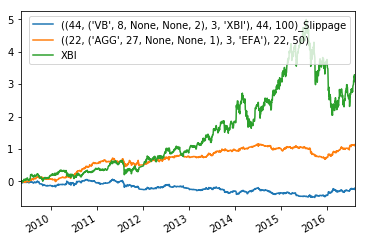

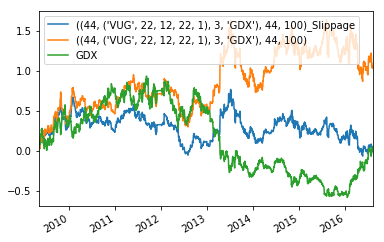

((22, ('XLP', 18, None, None, 1), 7, 'AGG'), 22, 300)
((22, ('XLP', 18, None, None, 1), 7, 'AGG'), 22, 300)_Slippage    0.229940
((22, ('XLP', 18, None, None, 1), 7, 'AGG'), 22, 300)             0.906354
AGG                                                               1.279928
dtype: float64
RELATIVE SHARPE -0.291870879563 RELATIVE SHARPE SLIPPAGE -0.820348884818
7


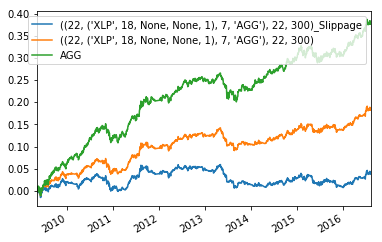

((44, ('DXJ', 2, 11, 6, 3), 7, 'EWZ'), 44, 50)
((44, ('DXJ', 2, 11, 6, 3), 7, 'EWZ'), 44, 50)_Slippage    0.347161
((44, ('DXJ', 2, 11, 6, 3), 7, 'EWZ'), 44, 50)             0.482486
EWZ                                                        0.064813
dtype: float64
RELATIVE SHARPE 6.44427413393 RELATIVE SHARPE SLIPPAGE 4.35635302652
7


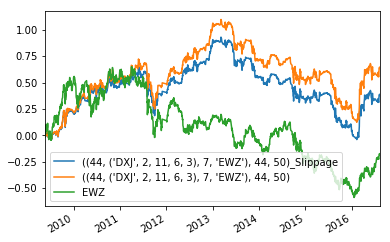

((5, ('MDY', 14, 5, None, 1), 7, 'XLY'), 5, 100)
((5, ('MDY', 14, 5, None, 1), 7, 'XLY'), 5, 100)_Slippage    0.591338
((5, ('MDY', 14, 5, None, 1), 7, 'XLY'), 5, 100)             0.860875
XLY                                                          1.117558
dtype: float64
RELATIVE SHARPE -0.229681615372 RELATIVE SHARPE SLIPPAGE -0.470865898662
7


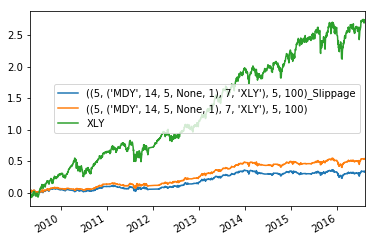

((22, ('AGG', 27, None, None, 1), 3, 'EFA'), 22, 50)
((22, ('AGG', 27, None, None, 1), 3, 'EFA'), 22, 50)_Slippage    0.077605
((22, ('AGG', 27, None, None, 1), 3, 'EFA'), 22, 50)             0.819842
EFA                                                              0.451517
dtype: float64
RELATIVE SHARPE 0.815751414893 RELATIVE SHARPE SLIPPAGE -0.828124294475
3


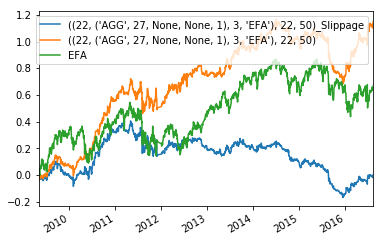

((5, ('USO', 27, 6, None, 1), 7, 'DIA'), 5, 300)
((5, ('USO', 27, 6, None, 1), 7, 'DIA'), 5, 300)_Slippage    0.766669
((5, ('USO', 27, 6, None, 1), 7, 'DIA'), 5, 300)             1.026140
DIA                                                          0.966585
dtype: float64
RELATIVE SHARPE 0.061613392246 RELATIVE SHARPE SLIPPAGE -0.206827262607
7


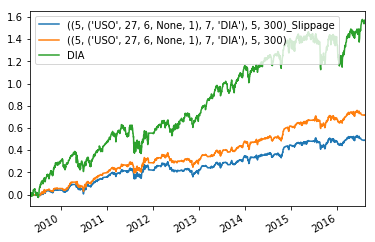

((44, ('VGK', 5, None, None, 1), 3, 'IWM'), 44, 100)
((44, ('VGK', 5, None, None, 1), 3, 'IWM'), 44, 100)_Slippage   -0.225745
((44, ('VGK', 5, None, None, 1), 3, 'IWM'), 44, 100)             0.518955
IWM                                                              0.751067
dtype: float64
RELATIVE SHARPE -0.309043177684 RELATIVE SHARPE SLIPPAGE -1.30056543278
3


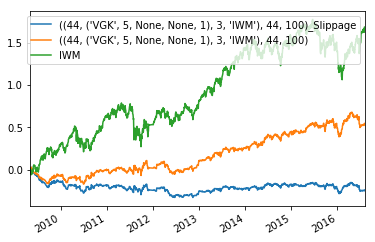

((10, ('IEF', 42, None, None, 3), 3, 'FXE'), 10, 25)
((10, ('IEF', 42, None, None, 3), 3, 'FXE'), 10, 25)_Slippage   -1.457836
((10, ('IEF', 42, None, None, 3), 3, 'FXE'), 10, 25)             0.340746
FXE                                                             -0.179575
dtype: float64
RELATIVE SHARPE -2.89751328428 RELATIVE SHARPE SLIPPAGE 7.11825516724
3


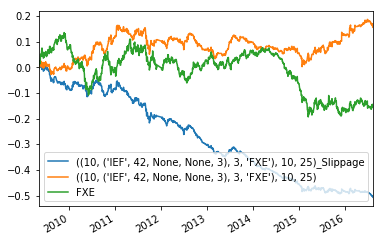

((10, ('USO', 44, None, 5, 1), 7, 'IWD'), 10, 50)
((10, ('USO', 44, None, 5, 1), 7, 'IWD'), 10, 50)_Slippage    0.748588
((10, ('USO', 44, None, 5, 1), 7, 'IWD'), 10, 50)             0.940119
IWD                                                           0.871923
dtype: float64
RELATIVE SHARPE 0.0782137041665 RELATIVE SHARPE SLIPPAGE -0.14145168139
7


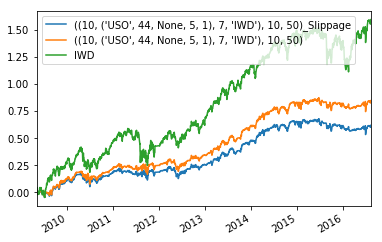

In [29]:
##PERFORM SANITY CHECK
import empyrical
import portfolioGeneration
import matplotlib.pyplot as plt
for i in range(len(modelReturns.columns)):
    item = modelReturns.columns[i]
    allocations = modelPredictions[[item]][:-252]
    allocations.columns = [uniqueModels[i].inputSeries.targetTicker]
    print(uniqueModels[i].describe())
    allocationPerformance, unu, unus = portfolioGeneration.calculatePerformanceForAllocations(allocations, joinedData)
    allocationPerformance.columns = [str(uniqueModels[i].describe()) + "_Slippage"]
    factorToExamine = uniqueModels[i].inputSeries.targetTicker
    factorReturn = dataAck.getDailyFactorReturn(factorToExamine, joinedData)
    factorReturn.columns = [uniqueModels[i].inputSeries.targetTicker]
    monsterDF = allocationPerformance.join(modelReturns[[item]]).join(factorReturn)
    empyrical.cum_returns(monsterDF).plot()
    transformedSharpe = monsterDF.apply(lambda x:empyrical.sharpe_ratio(x), axis=0)
    print(transformedSharpe)
    relativeSharpe = (transformedSharpe[str(uniqueModels[i].describe())] - transformedSharpe[uniqueModels[i].inputSeries.targetTicker])/transformedSharpe[uniqueModels[i].inputSeries.targetTicker]
    relativeSharpeSlippage = (transformedSharpe[str(uniqueModels[i].describe()) + "_Slippage"] - transformedSharpe[uniqueModels[i].inputSeries.targetTicker])/transformedSharpe[uniqueModels[i].inputSeries.targetTicker]
    data = dataAck.getModelInformationByKey([portfolio.getModelHash(uniqueModels[i])])[0]
    print("RELATIVE SHARPE", relativeSharpe, "RELATIVE SHARPE SLIPPAGE", relativeSharpeSlippage)
    print(uniqueModels[i].inputSeries.predictionPeriod)
    plt.show()

,"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)","((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)","((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)","((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)","((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)","((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)","((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)","((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)","((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",Factor Return
"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)",1.000000,0.299586,0.361516,0.080119,0.258076,0.145291,0.203028,0.411027,0.080046,0.510203
"((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)",0.299586,1.000000,0.192101,0.029264,0.072288,0.047432,0.098660,0.144577,0.019973,0.270357
"((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)",0.361516,0.192101,1.000000,0.229095,0.382568,0.111080,0.255624,0.458611,0.276160,0.418490
"((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)",0.080119,0.029264,0.229095,1.000000,0.139398,0.096351,0.107538,0.211629,0.082706,0.077791
"((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)",0.258076,0.072288,0.382568,0.139398,1.000000,0.138176,0.282684,0.303221,0.545019,0.389455
"((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)",0.145291,0.047432,0.111080,0.096351,0.138176,1.000000,0.171520,0.223435,0.071180,0.154845
"((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)",0.203028,0.098660,0.255624,0.107538,0.282684,0.171520,1.000000,0.205648,0.120847,0.323344
"((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)",0.411027,0.144577,0.458611,0.211629,0.303221,0.223435,0.205648,1.000000,0.101910,0.359140
"((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",0.080046,0.019973,0.276160,0.082706,0.545019,0.071180,0.120847,0.101910,1.000000,0.358881
Factor Return,0.510203,0.270357,0.418490,0.077791,0.389455,0.154845,0.323344,0.359140,0.358881,1.000000


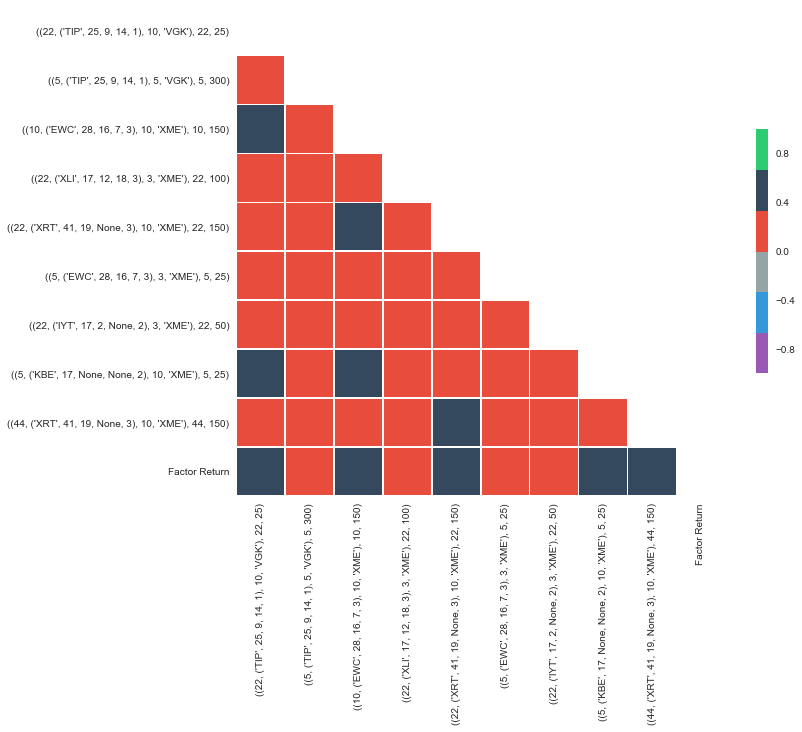

,"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)","((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)","((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)","((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)","((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)","((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)","((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)","((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)","((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",Factor Return
"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)",0.000054,0.000019,0.000024,0.000010,0.000017,0.000013,0.000019,0.000023,0.000006,0.000036
"((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)",0.000019,0.000070,0.000014,0.000004,0.000006,0.000005,0.000010,0.000009,0.000002,0.000022
"((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)",0.000024,0.000014,0.000080,0.000033,0.000031,0.000013,0.000029,0.000031,0.000025,0.000036
"((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)",0.000010,0.000004,0.000033,0.000263,0.000021,0.000020,0.000022,0.000026,0.000014,0.000012
"((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)",0.000017,0.000006,0.000031,0.000021,0.000083,0.000016,0.000032,0.000021,0.000051,0.000034
"((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)",0.000013,0.000005,0.000013,0.000020,0.000016,0.000158,0.000027,0.000021,0.000009,0.000019
"((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)",0.000019,0.000010,0.000029,0.000022,0.000032,0.000027,0.000156,0.000020,0.000015,0.000039
"((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)",0.000023,0.000009,0.000031,0.000026,0.000021,0.000021,0.000020,0.000058,0.000008,0.000026
"((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",0.000006,0.000002,0.000025,0.000014,0.000051,0.000009,0.000015,0.000008,0.000105,0.000035
Factor Return,0.000036,0.000022,0.000036,0.000012,0.000034,0.000019,0.000039,0.000026,0.000035,0.000092


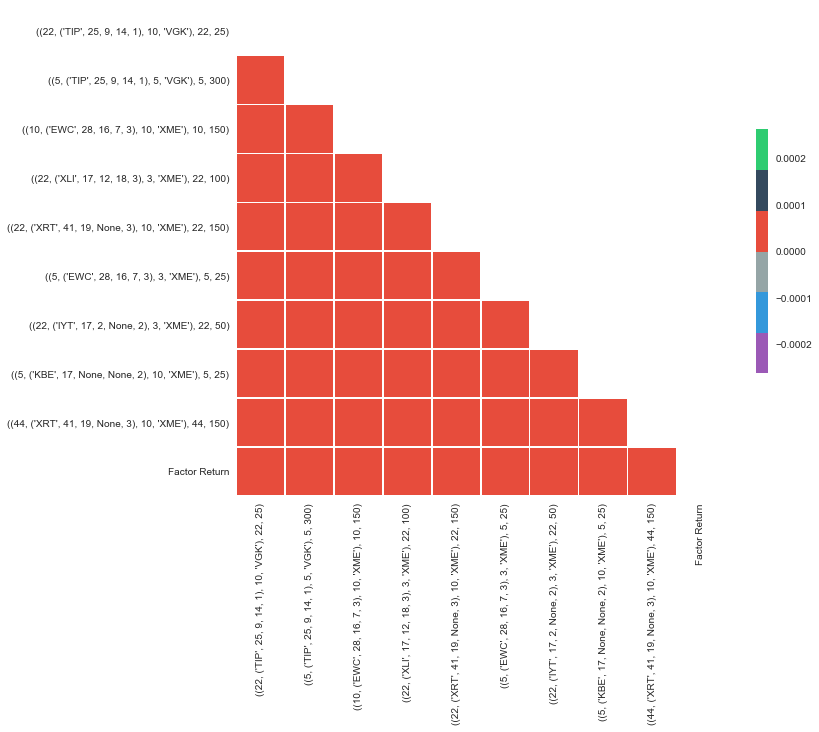

In [10]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [10]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
NEED TO STORE 1981
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
NEED TO STORE 1981
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
NEED TO STORE 1981
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
NEED TO STORE 1981
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
NEED TO STORE 1981
((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)
NEED TO STORE 1981
((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)
NEED TO STORE 1981
((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)
NEED TO STORE 1981
((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)
NEED TO STORE 1981


In [11]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="HIGH RELATIVE SHARPE ALLOCATION vs SPY", benchmark=factorToTrade, portfolioType="EW By Ticker")
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
display(portfolioInfo)

PORTFOLIO HASH: 7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e
1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67
43b82397f03341692c8167a264422c295b817c6251490db92125aa0c
5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1
6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0
85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2
8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094
9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd
e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c


<Entity('walkforward_portfolio_info', '7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e') {'description': 'HIGH RELATIVE SHARPE ALLOCATION vs SPY', 'portfolioType': 'EW By Ticker', 'benchmark': 'SPY'}>

In [12]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['43b82397f03341692c8167a264422c295b817c6251490db92125aa0c',
 '8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780',
 '8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094',
 'e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c',
 '85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2',
 '6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0',
 '5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1',
 '1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67',
 '9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd']

In [13]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [14]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-05-19,0.012015,NaN,0.012015,-0.000047,0.000392,0.013516,0.012015,NaN,0.001896
2009-05-20,-0.000000,NaN,-0.023192,0.000181,-0.000050,-0.026907,-0.000000,NaN,-0.000325
2009-05-21,-0.000000,NaN,-0.000000,0.000042,0.000514,-0.004303,0.003577,NaN,0.005057
2009-05-22,0.000000,NaN,-0.021902,-0.000428,0.000674,0.026779,-0.043804,NaN,0.015694
2009-05-26,-0.000000,NaN,-0.000000,0.000057,0.000060,-0.002548,0.002071,NaN,-0.015451
2009-05-27,0.000000,NaN,0.000000,-0.000433,-0.000606,0.013689,0.000000,NaN,0.011927
2009-05-28,-0.013426,NaN,0.013426,-0.000734,-0.001599,0.016310,0.013426,NaN,0.017060
2009-05-29,-0.034073,NaN,0.034073,-0.002529,-0.002954,0.040462,0.068146,NaN,0.024398
2009-06-01,-0.002411,NaN,0.000000,-0.000471,-0.001944,0.005575,0.009644,NaN,0.013099
2009-06-02,0.016103,NaN,0.032207,0.004152,0.005528,-0.035729,-0.064413,NaN,-0.032912


In [15]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-06-19,-0.043757,-0.000171,0.043757,0.023588,-0.009804,0.002735,0.087513,0.049226,-0.034858
2009-06-22,0.000000,0.000101,-0.012883,-0.007096,0.004597,-0.002013,-0.025766,-0.013285,0.011569
2009-06-23,-0.008931,0.000035,-0.017862,-0.004849,0.001186,-0.002163,-0.017862,-0.008443,0.002148
2009-06-24,-0.046888,0.000092,-0.023444,-0.012271,0.007929,-0.007693,-0.046888,-0.019415,0.012377
2009-06-25,0.008905,-0.000017,-0.000000,0.002261,-0.001526,0.001739,0.004453,0.003200,-0.001756
2009-06-26,-0.001586,0.000000,0.000793,-0.000378,0.008099,-0.000365,0.000000,-0.000465,0.006731
2009-06-29,0.011741,-0.000000,-0.023483,0.005091,-0.007180,0.005962,-0.000000,0.005320,-0.005406
2009-06-30,0.000000,-0.000000,0.000000,-0.000000,0.014288,-0.000000,0.000000,-0.000000,0.007495
2009-07-01,-0.000000,0.000158,-0.000000,0.004855,-0.022157,0.007705,-0.000000,0.002322,-0.007272
2009-07-02,-0.000000,0.000504,-0.000000,0.008172,-0.005583,0.014931,0.025826,0.000807,-0.001734


,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-06-19,0.50,0.001953,-0.5,-0.269531,0.281250,-0.031250,-1.00,-0.562500,1.0000
2009-06-22,0.00,0.003906,-0.5,-0.275391,0.347656,-0.078125,-1.00,-0.515625,0.8750
2009-06-23,-0.50,0.001953,-1.0,-0.271484,0.414062,-0.121094,-1.00,-0.472656,0.7500
2009-06-24,-1.00,0.001953,-0.5,-0.261719,0.480469,-0.164062,-1.00,-0.414062,0.7500
2009-06-25,-1.00,0.001953,0.0,-0.253906,0.542969,-0.195312,-0.50,-0.359375,0.6250
2009-06-26,-1.00,0.000000,0.5,-0.238281,0.601562,-0.230469,0.00,-0.292969,0.5000
2009-06-29,-0.50,0.000000,1.0,-0.216797,0.664062,-0.253906,0.00,-0.226562,0.5000
2009-06-30,0.00,-0.001953,0.5,-0.203125,0.714844,-0.269531,0.50,-0.152344,0.3750
2009-07-01,0.00,-0.005859,0.0,-0.179688,0.761719,-0.285156,0.00,-0.085938,0.2500
2009-07-02,0.00,-0.009766,0.0,-0.158203,0.804688,-0.289062,-0.50,-0.015625,0.2500


In [37]:
cleanedAggregateReturns

,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094
2009-05-19,0.000392,0.012015,0.001896,0.012015,-0.000047,0.013516,0.012015
2009-05-20,-0.000050,-0.000000,-0.000325,-0.000000,0.000181,-0.026907,-0.023192
2009-05-21,0.000514,-0.000000,0.005057,0.003577,0.000042,-0.004303,-0.000000
2009-05-22,0.000674,0.000000,0.015694,-0.043804,-0.000428,0.026779,-0.021902
2009-05-26,0.000060,-0.000000,-0.015451,0.002071,0.000057,-0.002548,-0.000000
2009-05-27,-0.000606,0.000000,0.011927,0.000000,-0.000433,0.013689,0.000000
2009-05-28,-0.001599,-0.013426,0.017060,0.013426,-0.000734,0.016310,0.013426
2009-05-29,-0.002954,-0.034073,0.024398,0.068146,-0.002529,0.040462,0.034073
2009-06-01,-0.001944,-0.002411,0.013099,0.009644,-0.000471,0.005575,0.000000
2009-06-02,0.005528,0.016103,-0.032912,-0.064413,0.004152,-0.035729,0.032207


In [17]:
portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)

[0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.25000000000000006,
 0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.25000000000000006]

In [18]:
if portfolioInfo["portfolioType"] == "HRP":
    print("HRP")
    ##HRP ALLOCATION
    hrpReturns, historicalWeights = portfolioGeneration.\
            produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
            22, startIndex=None, maxWindowSize=True)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW":
    print("EW")
    ##EW ALLOCATION
    ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                     None)
    display(ewReturns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW By Ticker":
    print("EW By Ticker")
    weightArray = portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: weightArray, axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
    

EW By Ticker


In [19]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"],
    "portfolioType":portfolioInfo["portfolioType"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData)

{'key': '7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e', 'description': 'HIGH RELATIVE SHARPE ALLOCATION vs SPY', 'benchmark': 'SPY', 'portfolioType': 'EW By Ticker'}
((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)
((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
